In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings


In [3]:
SECONDS_IN_YEAR = 60*60*24*365 #s
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

data_path = "F:\\Local Data\\ClimateBench\\"

# Only future scenarios for now
inputs = glob(data_path + "inputs_s*.nc")

def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).mean(['latitude', 'longitude'])


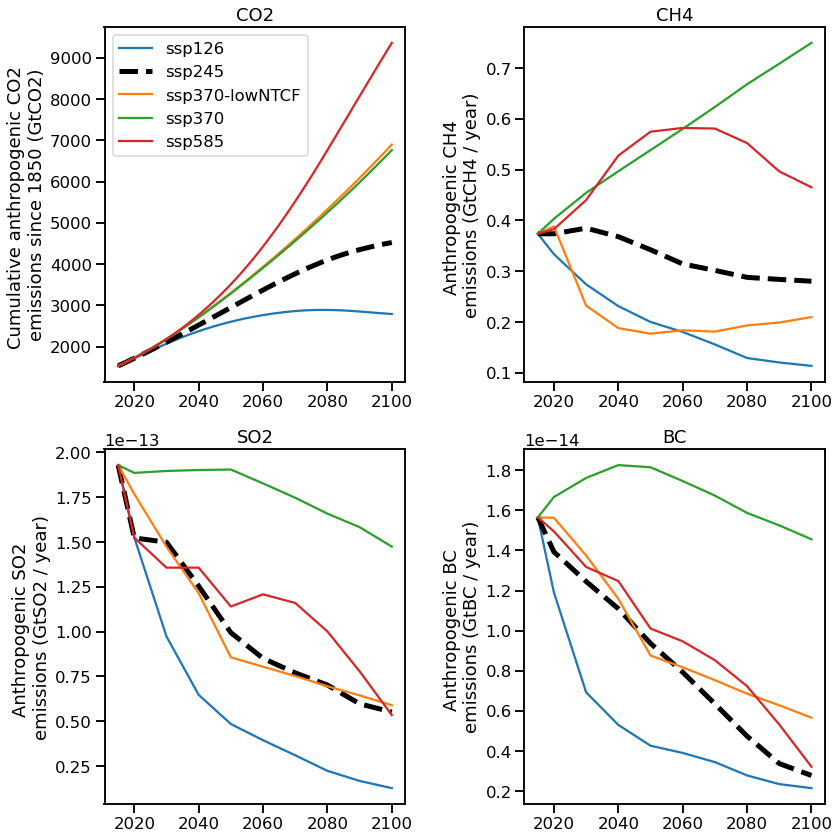

In [4]:
with sns.plotting_context("talk"):

    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    for input in inputs:
        label=input.split('_')[1][:-3]
        X = xr.open_dataset(input)
        x = range(2015, 2101)
        
        kwargs = {}
        if label == "ssp245":
            kwargs['color'] = 'black'
            kwargs['ls'] = '--'
            kwargs['lw'] = '5'
        axes[0, 0].plot(x, X['CO2'], label=label, **kwargs)
        axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
        axes[0, 1].plot(x, X['CH4'], label=label, **kwargs)
        axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
        # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
        axes[1, 0].plot(x, convert(global_mean(X['SO2']*1000)), label=label, **kwargs)
        axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
        axes[1, 1].plot(x, convert(global_mean(X['BC']*1000)), label=label, **kwargs)
        axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

    axes[0, 0].set_title('CO2')
    axes[0, 1].set_title('CH4')
    axes[1, 0].set_title('SO2')
    axes[1, 1].set_title('BC')
    axes[0, 0].legend()
    plt.tight_layout()

In [5]:
# Get one combined historical + ssp585 timeseries for now
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp245.nc']).compute()
# Take the 2nd ensemble member for the historical (the first one has some missing DTR values for some reason...) and the 1st (only) one for SSP585
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp245.nc').sel(member=1)], dim='time').compute()

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [14]:
# Leave the projection as PlateCarree for dev then Mollweide for final plots (it's slow!)
proj = ccrs.Mollweide() # ccrs.PlateCarree()

# Alternative approaches....:
# Sort the coordinates so that contourf works properly (pcolormesh takes forever in this projection)
# X.coords['longitude'] = (X.coords['longitude'] + 180) % 360 - 180
# X = X.sortby(X.longitude)
# Try adding a cyclic point, but losses the xarray goodness..
# from cartopy.util import add_cyclic_point 

In [6]:
# with sns.plotting_context("talk"):

#     fig = np.log(X["SO2"].sel(time=[1850, 1970, 2020, 2100])).plot.pcolormesh(col='time',col_wrap=2, vmin=-27, vmax=-20,  transform=ccrs.PlateCarree(),
#                                                                               subplot_kws=dict(projection=proj), figsize=(18, 8),
#                                                                               cbar_kwargs=dict(label='Log anthropogenic SO2 emissions (log kg / m2 / s)'))


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\xarray\core\computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


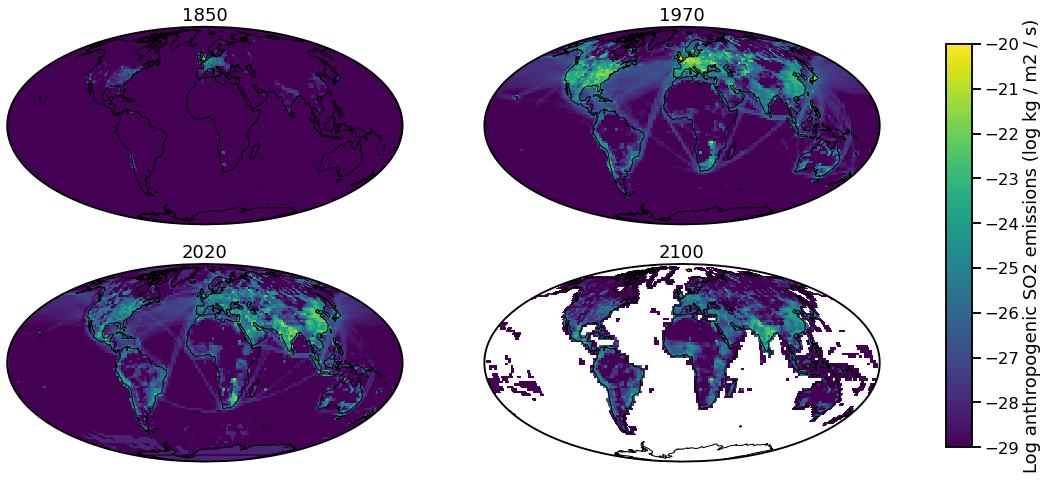

In [13]:
with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(18, 8))
    plt.subplot(221, projection=proj)
    np.log(X["SO2"].sel(time=1850)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('1850')

    plt.subplot(222, projection=proj)
    np.log(X["SO2"].sel(time=1970)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('1970')

    plt.subplot(223, projection=proj)
    np.log(X["SO2"].sel(time=2020)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('2020')

    plt.subplot(224, projection=proj)
    m=np.log(X["SO2"].sel(time=2100)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('2100')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax)
    cbar.set_label('Log anthropogenic SO2 emissions (log kg / m2 / s)')

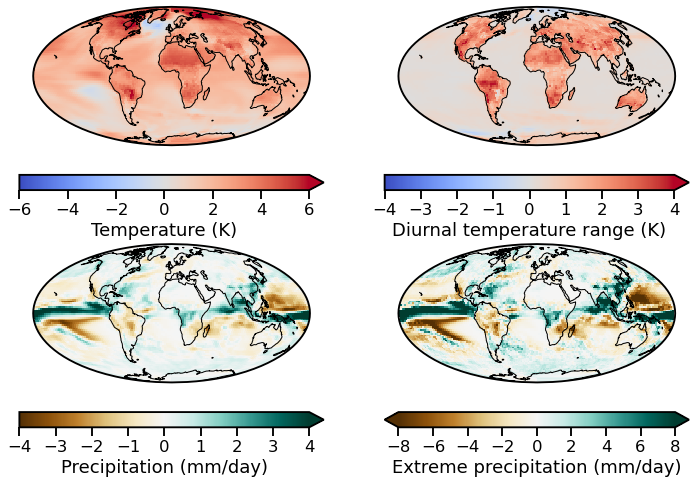

In [8]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=6)

with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(12, 8))
    plt.subplot(221, projection=proj)
    Y["tas"].sel(time=2100).plot(cmap="coolwarm", vmax=6, transform=ccrs.PlateCarree(), add_labels=False,
                                  cbar_kwargs={"label":"Temperature (K)", "orientation":'horizontal'})
    plt.gca().coastlines()

    plt.subplot(222, projection=proj)
    Y["diurnal_temperature_range"].sel(time=2100).plot(cmap="coolwarm", vmax=4, transform=ccrs.PlateCarree(), add_labels=False,
                                                      cbar_kwargs={"label":"Diurnal temperature range (K)", "orientation":'horizontal'})
    plt.gca().coastlines()

    plt.subplot(223, projection=proj)
    #  Convert precip to mm/day
    (Y["pr"].sel(time=2100)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-4, vmax=4, add_labels=False,
                                 cbar_kwargs={"label":"Precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()

    plt.subplot(224, projection=proj)
    (Y["pr90"].sel(time=2100)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-8, vmax=8, add_labels=False,
                                   cbar_kwargs={"label":"Extreme precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()



In [6]:
variables = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']
rf_predictions = xr.open_dataset(data_path + 'outputs_ssp245_predict_RF.nc')
nn_predictions = xr.open_dataset(data_path + 'outputs_ssp245_predict_cnn_lstm.nc')
gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + "outputs_ssp245_predict_gp_{}.nc".format(v))} for v in variables])

In [7]:
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [9]:
models = [rf_predictions, nn_predictions, gp_predictions, Y]
model_labels = ['Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\duncan\miniconda3\envs\clima

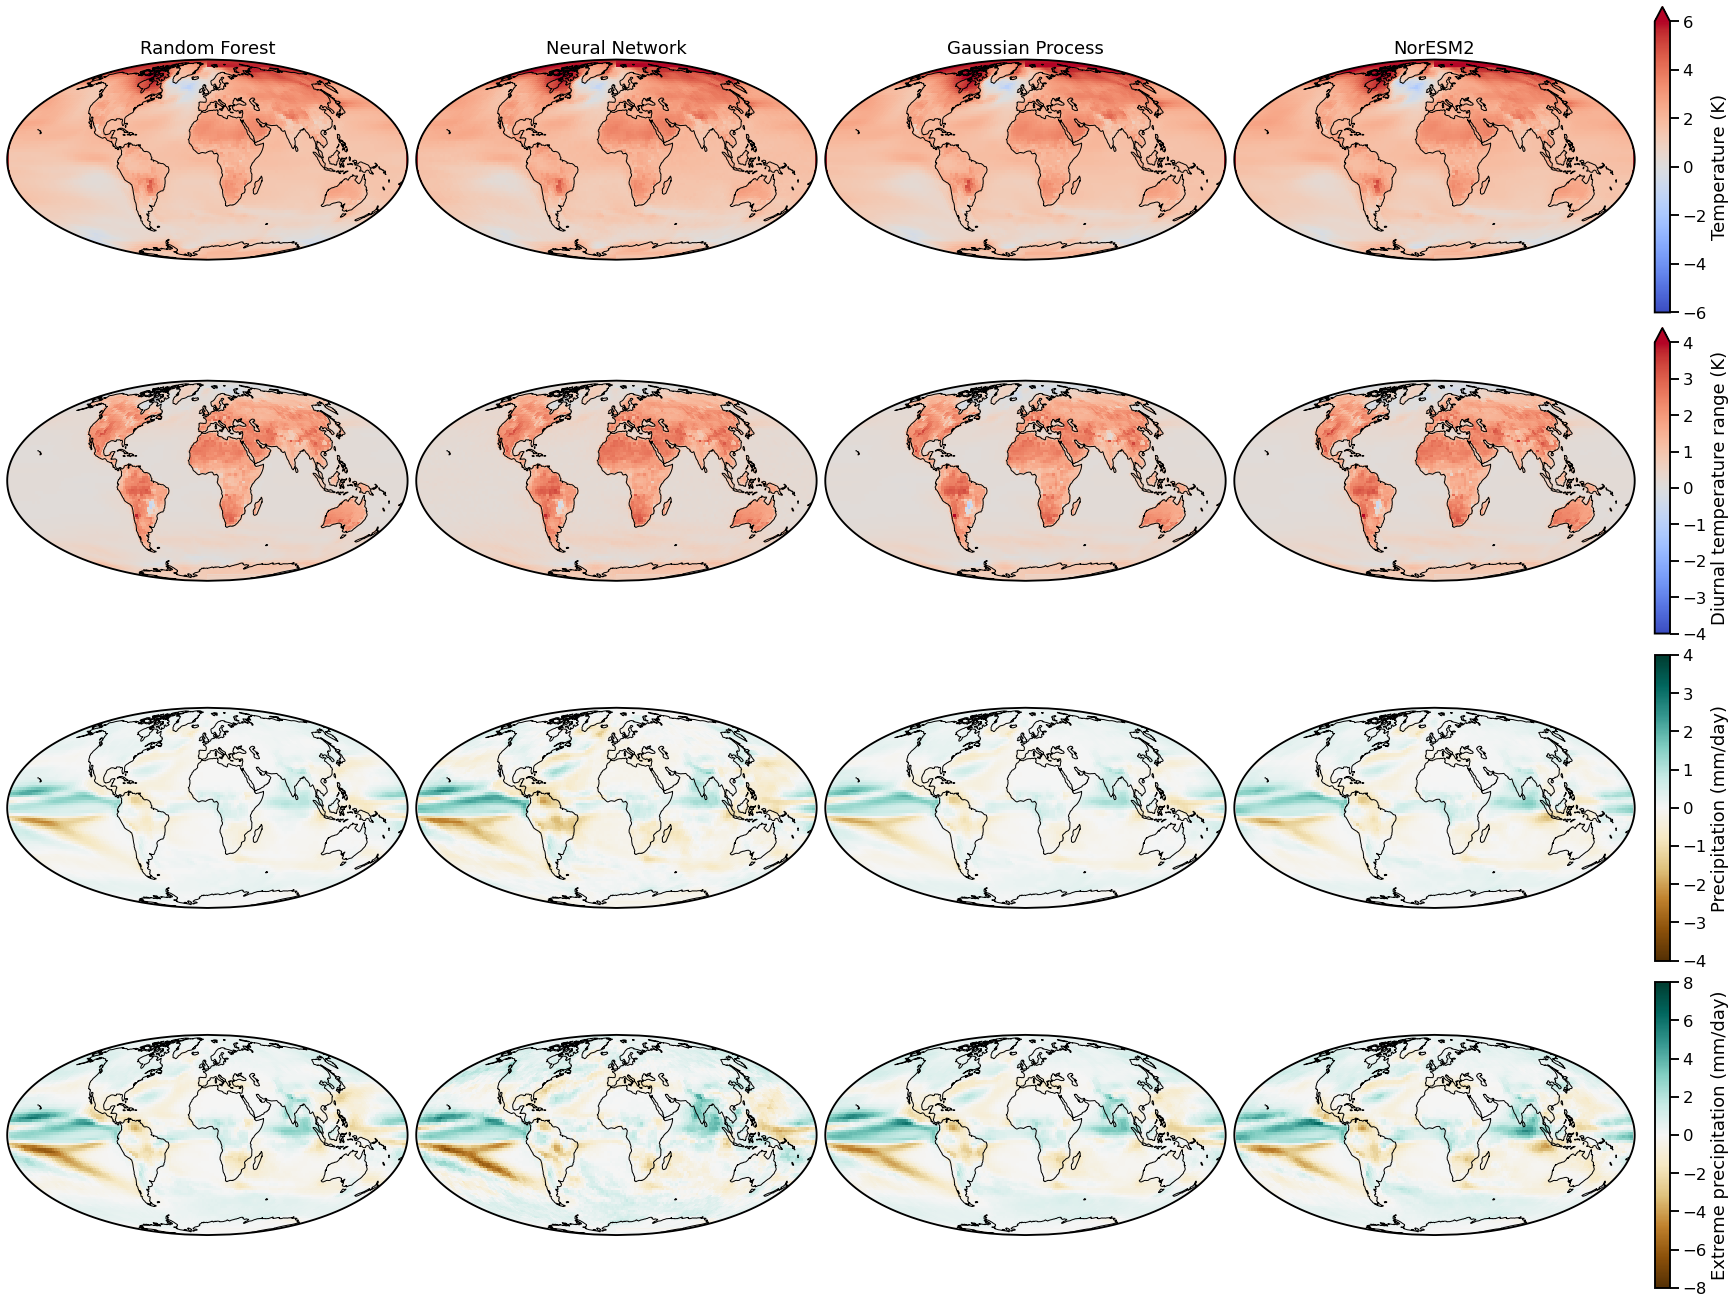

In [35]:
with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models, model_labels):
            if label == 'Temperature (K)':
                ax.set_title(model_label)
            if model_label == 'NorESM2':
                model[var].sel(time=slice(2050, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else: 
                model[var].sel(time=slice(2050, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            ax.coastlines()
                

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\duncan\miniconda3\envs\clima

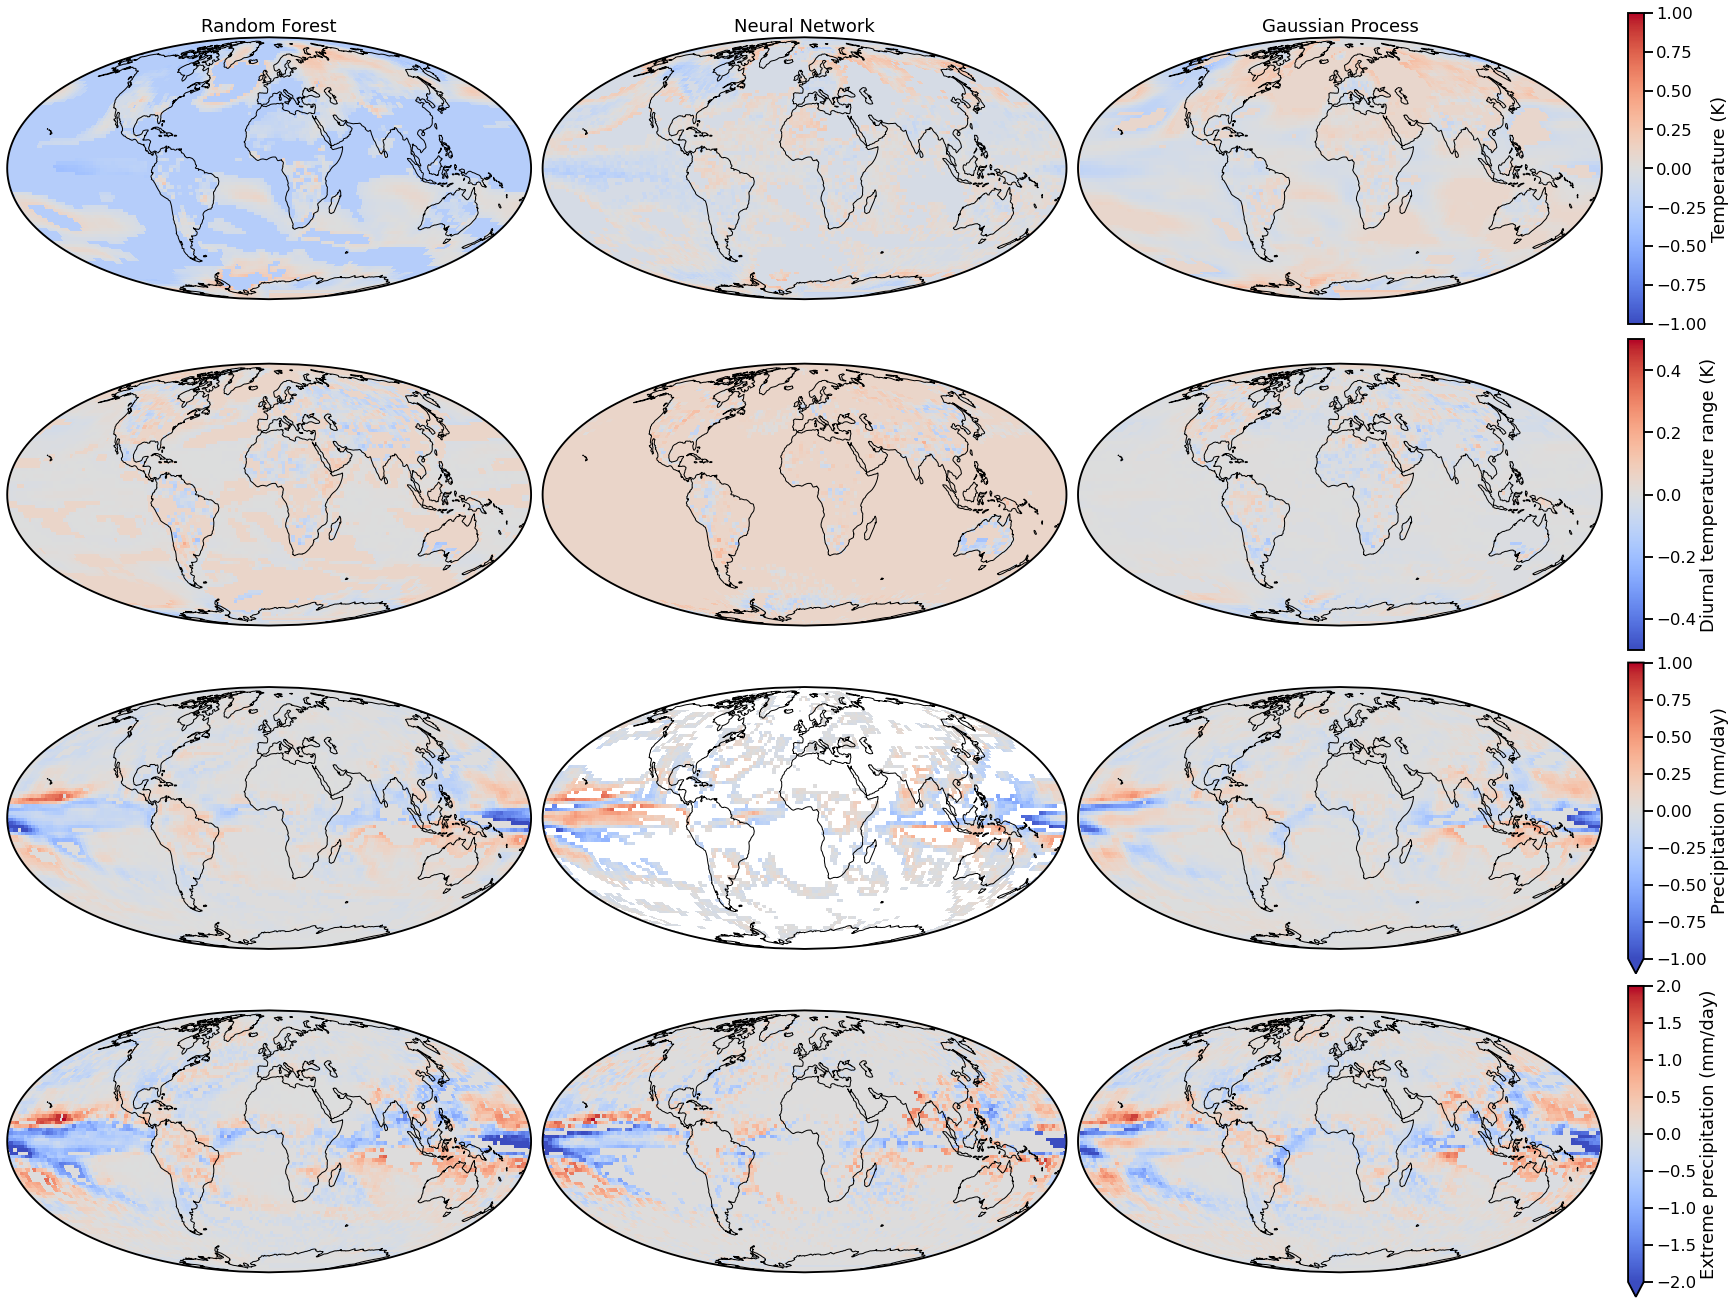

In [15]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

# proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]


with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[:-1], model_labels[:-1]):
            if label == 'Temperature (K)':
                ax.set_title(model_label)
            diff = (model[var]-models[-1][var]).sel(time=slice(2050, 2100)) # /models[-1][var]
            mean_diff = diff.mean('time')
            _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
            if model_label == 'Gaussian Process':
                mean_diff.where(p > p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else:
                mean_diff.where(p > p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
            ax.coastlines()
                

In [71]:
nn_predictions = xr.merge([{v: xr.open_dataarray(data_path + "outputs_ssp245_predict_{}.nc".format(v))} for v in variables])
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

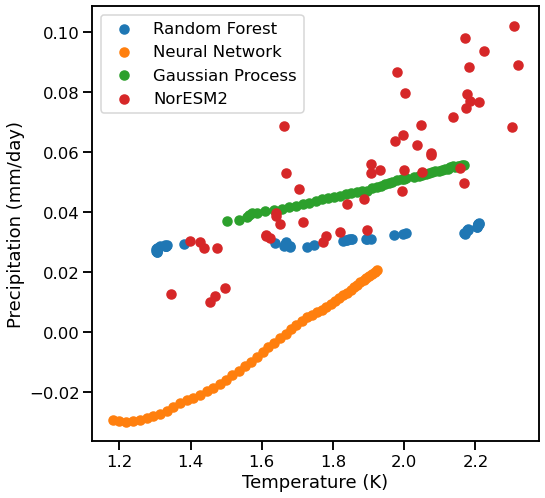

In [72]:
models = [rf_predictions, nn_predictions, gp_predictions, Y]
model_labels = ['Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2050, 2100))), global_mean(model['pr'].sel(time=slice(2050, 2100))), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()
                

In [73]:
print(global_mean(nn_predictions))
print(global_mean(rf_predictions))

<xarray.Dataset>
Dimensions:                    (time: 86)
Coordinates:
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
Data variables:
    tas                        (time) float64 0.5815 0.6007 ... 1.917 1.924
    diurnal_temperature_range  (time) float64 0.6234 0.6241 ... 0.6747 0.675
    pr                         (time) float64 0.0009079 0.003199 ... 0.02068
    pr90                       (time) float64 0.07836 0.084 ... 0.2775 0.2792
<xarray.Dataset>
Dimensions:                    (time: 86)
Coordinates:
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
Data variables:
    tas                        (time) float64 0.7822 0.7902 ... 2.208 2.211
    diurnal_temperature_range  (time) float64 0.6235 0.6237 ... 0.6341 0.6341
    pr                         (time) float64 -0.003881 -0.003586 ... 0.03641
    pr90                       (time) float64 -0.009286 -0.008491 ... 0.08413


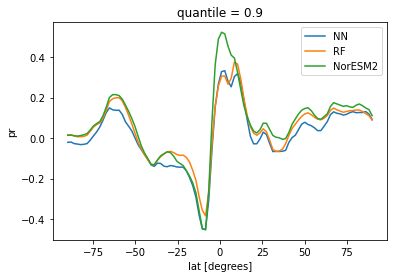

In [75]:
nn_predictions.sel(time=slice(2050, 2100)).mean(['lon', 'time'])['pr'].plot(label='NN')
rf_predictions.sel(time=slice(2050, 2100)).mean(['lon', 'time'])['pr'].plot(label='RF')
Y.sel(time=slice(2050, 2100)).mean(['lon', 'time'])['pr'].plot(label='NorESM2')
plt.legend()

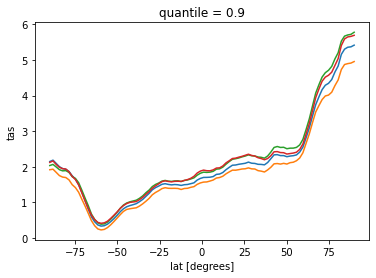

In [76]:
rf_predictions.sel(time=slice(2050, 2100)).mean(['lon', 'time'])['tas'].plot()
nn_predictions.sel(time=slice(2050, 2100)).mean(['lon', 'time'])['tas'].plot()
gp_predictions.sel(time=slice(2050, 2100)).mean(['lon', 'time'])['tas'].plot()
Y.sel(time=slice(2050, 2100)).mean(['lon', 'time'])['tas'].plot()

In [77]:
Y.sel()

<xarray.Dataset>
Dimensions:                    (time: 251, lat: 96, lon: 144)
Coordinates:
  * time                       (time) int64 1850 1851 1852 ... 2098 2099 2100
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
    quantile                   float64 0.9
    member                     (time) int64 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
Data variables:
    diurnal_temperature_range  (time, lat, lon) float32 0.6425 ... 0.03087
    tas                        (time, lat, lon) float32 0.4695 0.4688 ... 4.515
    pr                         (time, lat, lon) float32 0.01545 ... 0.1307
    pr90                       (time, lat, lon) float64 0.02647 ... 0.502